In [1]:
#meta: 4/28/2020 Ex2 Part2.  Logistic regression.  
# Regularized logistic regression - predict whether microchips from a fabrication plant pass quality assurance.  
# src Coursera, Standford ML course - refactor in python
# src for markup  https://github.com/dibgerge/ml-coursera-python-assignments.git
#see ex2.pdf
#Numbering per original assignments

#here 04/28/2020 Regularized Logistic Regression
#      numpy for data load (not pandas)
#      Feature engineering: polynomial features
#      Reuse ML functions: myUtils.ml
#      sigmoid(), predict(), costFunction().
#      Modify Cost function - add regularization.
#      Visualize data before and after modeling, draw the Decision Boundary.
#      Compare regularized models with diff lambdas
#      Compare regularized models with non-regularized


In [2]:
import numpy as np

# Plot
import matplotlib.pyplot as plt
%matplotlib inline

# Optimization module in scipy
from scipy import optimize

#import my utils
from myUtils import ml as myML  # my own module


# 2. Regularized Logistic Regression

Implement a regularized logistic regression  to predict whether microchips from a fabrication plant passes quality assurance. 

## Microchip Quality Assurance.
During QA, each microchip goes through various tests to ensure it is functioning correctly.  Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.  

Dataset:  
*x* - two test scores  
*y* - test result 1=accepted, 0=rejected  


## 2.0 Load data

Dims: m x n  => records x features

In [4]:
data = np.loadtxt('data/ex2/ex2data2.txt', delimiter=',',skiprows=0) #unpack=True
print(data.shape)

#preview data
print("Preview data")
data[0:5]


(118, 3)
Preview data


array([[ 0.051267,  0.69956 ,  1.      ],
       [-0.092742,  0.68494 ,  1.      ],
       [-0.21371 ,  0.69225 ,  1.      ],
       [-0.375   ,  0.50219 ,  1.      ],
       [-0.51325 ,  0.46564 ,  1.      ]])

## 2.1 Visualizing the data
Get acquainted with the learning dataset.  We see a figure, where the axes are the two test scores, and the positive (y = 1, accepted) and negative (y = 0, rejected) examples are shown with different markers.

In [5]:
#prep data
X=data[:,[0,1]]
y=data[:, 2]
print ("Number of data points: {}".format(y.size))



Number of data points: 118


In [6]:
def plotData(X, y):
    """
    Plot the positive and negative examples on a 2D plot

    Parameters
    ----------
    X : array_like
        Features, mxn matrix.
        Data point values for both x and y axes.

    y : array_like
        Binary label values for the dataset. A vector of size (m, ).

    
    Instructions
    ------------
    Plot the positive and negative examples on a 2D plot, using the
    option 'k*' for the positive examples and 'ko' for the negative examples.


    Vis options
    ----
    'ro' red circles. 
    'ms'=10 larger marker size
    'mec' marker edge color
    """

    # ====================== CODE  ======================
    
    #find positive vs negative
    idx_positive = np.where(y==1,True, False) #class numpy.ndarray
    
    plt.plot(X[idx_positive, 0], X[idx_positive, 1], 'k*', ms=7, label='Accepted')
    plt.plot(X[~idx_positive, 0], X[~idx_positive, 1], 'yo', ms=7, label='Rejected')

    # ============================================================

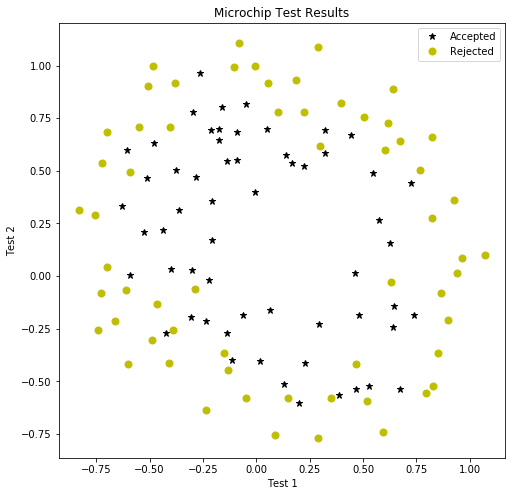

In [7]:
plt.figure(figsize=(8,8))
plt.title('Microchip Test Results')
plotData(X,y)
plt.xlabel('Test 1')
plt.ylabel ('Test 2')
plt.legend()
plt.show()

The above figure shows that our dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straight-forward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.

## 2.2 Feature mapping

One way to fit the data better is to create more features from each data point. In the predefined function `mapFeature`, we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

$$ \text{mapFeature}(x) = \begin{bmatrix} 1 & x_1 & x_2 & x_1^2 & x_1 x_2 & x_2^2 & x_1^3 & \dots & x_1 x_2^5 & x_2^6 \end{bmatrix}^T $$


In [8]:
def mapFeature(X1, X2, degree=6):
    """
    Maps the two input features to quadratic features used in the regularization exercise.
    Returns a new feature array with more features, comprising of
    X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..
    Parameters
    ----------
    X1 : array_like
        A vector of shape (m, 1), containing one feature for all examples.
    X2 : array_like
        A vector of shape (m, 1), containing a second feature for all examples.
        Inputs X1, X2 must be the same size.
    degree: int, optional
        The polynomial degree.
    Returns
    -------
    : array_like
        A matrix of of m rows, and columns depend on the degree of polynomial.
    """
    if X1.ndim > 0:
        out = [np.ones(X1.shape[0])]
    else:
        out = [np.ones(1)]

    for i in range(1, degree + 1):
        for j in range(i + 1):
            out.append((X1 ** (i - j)) * (X2 ** j))

    if X1.ndim > 0:
        return np.stack(out, axis=1)
    else:
        return np.array(out)

In [9]:
# add polynomial features
# note: mapFeature also handles the intercept term by adding a column of 1s
X = mapFeature(X[:,0], X[:,1])
print("X shape: ", X.shape)

X shape:  (118, 28)


As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector. A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.
While the feature mapping allows us to build a more expressive classifier, it also more susceptible to overfitting. In the next parts of the exercise, you will implement regularized logistic regression to fit the data and also see for yourself how regularization can help combat the overfitting problem.

## 2.3 Cost function and gradient

Now you will implement code to compute the cost function and gradient for regularized logistic regression. Complete the code for the function `costFunctionReg` below to return the cost and gradient.

Recall that the regularized cost function in logistic regression is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)}\log \left( h_\theta \left(x^{(i)} \right) \right) - \left( 1 - y^{(i)} \right) \log \left( 1 - h_\theta \left( x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Note that you should not regularize the parameters $\theta_0$. The gradient of the cost function is a vector where the $j^{th}$ element is defined as follows:

$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \qquad \text{for } j =0 $$

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m}\theta_j \qquad \text{for } j \ge 1 $$
<a id="costFunctionReg"></a>


In [10]:
# return the cost and gradient
# note: lecture        X dims: n x m => h = g(theta.T * X) 
#       vs 
#       here reversing X dims: m x n => h = g(X * theta)

def costFunctionReg(theta, X, y, lambda_=1):
    """
    Compute cost and gradient for logistic regression with regularization. 
    
    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). 
        n = number of features including any intercept. 
        If we have mapped our initial features into polynomial features, then 
        n = the total number of polynomial features. 
    
    X : array_like
        The input dataset with shape (m x n) where 
        m = total number of data points and 
        n = number of features (after feature mapping). 
        We assume the intercept has already been added to the input.
    
    y : array_like
        The data labels. A vector with shape (m, ).
        
    lambda_ : float
        The regularization parameter.
    
    Returns
    -------
    J : float
        The computed value for the regularized cost function. 
    
    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost J with respect to theta, at the current values of theta.
        
    Instructions
    ------------
    Compute J cost of a particular choice of theta.
    Compute the partial derivatives and set grad to the partial derivatives of the cost w.r.t. each param in theta.
    Note: Remember not to regularize param theta0 => explicitly exlude theta0 from cost function J
    
    myNotes revised
    ========= 
    y_hat = X * theta => (m, n+1) x (n+1, ) x  => shape (m, )     (same as y)
    error = y_hat - y =>                          shape (m, )     (same as y)
    gradient = vector                             shape (n+1, )   (same as theta)
    X.T * (error/m) => (n+1, m) x (m, 1) =>       shape (n+1, ) 

    to multiply: use np.dot(X, theta)
    
    refer: https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html
    """
    # Initialize vars
    m = y.size  # number of training examples

    # Return the following variables correctly 
    J = 0
    grad = np.zeros(theta.shape)

    # ====================== YOUR CODE HERE ======================
    #compute hypothesis
    #for linear regression was: y_hat = np.dot( X, theta)
    #for logistic regression 
    y_hat = myML.sigmoid( np.dot(X, theta))
     
    #compute cost 
    part1 = -y * np.log(y_hat)
    part2 = (1 - y) * np.log(1 - y_hat)
    #exclude theta0 from regularizing
    J = ((part1-part2).sum() / m) + (lambda_ * (theta[1:]**2).sum() / (2*m))
    
    #compute gradient -> hint: same dimension as theta, see myNotes
    #error = y_hat - y
    #grad = np.dot(X.T, (error/m)) 
    
    #exclude theta0 from regularizing => separately compute gradient0 
    grad[0] = np.dot(X[:,0], (y_hat - y)/m) # returns a scalar (1 x m) x (m x 1), same for np.dot((m,)x(m,))
    
    #y_hat_rest = myML.sigmoid( np.dot(X[:,1:], theta[1:]))
    grad[1:] = np.dot(X[:,1:].T, (y_hat - y)/m) + (lambda_ * theta[1:] / m) #same dims as theta - 1
    
    
    # =============================================================
    return J, grad
    

<div class="alert alert-block alert-info">
**Implementation Note:**<br>
Before proceeding we add the intercept term to X. 
</div>

In [11]:
# Setup the data matrix appropriately, and add ones for the intercept term
m, n = X.shape

print('# of features (with intercept): ', n)
print('# of records: ', m)


# of features (with intercept):  28
# of records:  118


Compute and display initial cost and gradient. Additional check with non-zero theta.

In [12]:
# Initialize fitting parameters
initial_theta = np.zeros(n)
print("Theta shape: ", initial_theta.shape)
print("X shape: ", X.shape)

# Set regularization parameter lambda to 1
lambda_ = 1;

# Compute and display initial cost and gradient for regularized logistic regression
cost, grad = costFunctionReg(initial_theta, X, y, lambda_)

print('Cost at initial theta (zeros): {:.3f}'.format(cost))
print('Expected cost (approx)       : 0.693\n')

print('Gradient at initial theta (zeros) - first five values only:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad[:5]))
print('Expected gradients (approx) - first five values only:')
print('\t[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]\n')


# Compute and display cost and gradient
# with all-ones theta and lambda = 10
test_theta = np.ones(X.shape[1])
cost, grad = costFunctionReg(test_theta, X, y, 10)

print('------------------------------\n')
print('Cost at test theta    : {:.2f}'.format(cost))
print('Expected cost (approx): 3.16\n')

print('Gradient at initial theta (zeros) - first five values only:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad[:5]))
print('Expected gradients (approx) - first five values only:')
print('\t[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]')

Theta shape:  (28,)
X shape:  (118, 28)
Cost at initial theta (zeros): 0.693
Expected cost (approx)       : 0.693

Gradient at initial theta (zeros) - first five values only:
	[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]
Expected gradients (approx) - first five values only:
	[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]

------------------------------

Cost at test theta    : 3.16
Expected cost (approx): 3.16

Gradient at initial theta (zeros) - first five values only:
	[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]
Expected gradients (approx) - first five values only:
	[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]


### 2.3.1 Learning parameters using `scipy.optimize`

Similar to the previous parts, you will use `optimize.minimize` to learn the optimal parameters $\theta$. If you have completed the cost and gradient for regularized logistic regression (`costFunctionReg`) correctly, you should be able to step through the next part of to learn the parameters $\theta$ using `optimize.minimize`.

For logistic regression, you want to optimize the cost function $J(\theta)$ with parameters $\theta$.
Concretely, you are going to use `optimize.minimize` to find the best parameters $\theta$ for the logistic regression cost function, given a fixed dataset (of X and y values). You will pass to `optimize.minimize` the following inputs:
- `costFunction`: A cost function that, when given the training set and a particular $\theta$, computes the logistic regression cost and gradient with respect to $\theta$ for the dataset (X, y). It is important to note that we only pass the name of the function without the parenthesis. This indicates that we are only providing a reference to this function, and not evaluating the result from this function.
- `initial_theta`: The initial values of the parameters we are trying to optimize.
- `(X, y)`: These are additional arguments to the cost function.
- `jac`: Indication if the cost function returns the Jacobian (gradient) along with cost value. (True)
- `method`: Optimization method/algorithm to use
- `options`: Additional options which might be specific to the specific optimization method. In the following, we only tell the algorithm the maximum number of iterations before it terminates.

If you have completed the `costFunction` correctly, `optimize.minimize` will converge on the right optimization parameters and return the final values of the cost and $\theta$ in a class object. Notice that by using `optimize.minimize`, you did not have to write any loops yourself, or set a learning rate like you did for gradient descent. This is all done by `optimize.minimize`: you only needed to provide a function calculating the cost and the gradient.

In the following, we already have code written to call `optimize.minimize` with the correct arguments.

In [13]:
initial_theta.shape

(28,)

In [14]:
# set options for optimize.minimize
options= {'maxiter': 400}
lambda_ = 1

# see documention for scipy's optimize.minimize  for description about
# the different parameters
# The function returns an object `OptimizeResult`
# We use truncated Newton algorithm for optimization which is 
# equivalent to MATLAB's fminunc
# See https://stackoverflow.com/questions/18801002/fminunc-alternate-in-numpy
res = optimize.minimize(costFunctionReg,
                        initial_theta,
                        (X, y, lambda_),
                        jac=True,
                        method='TNC',
                        options=options)

# the fun property of `OptimizeResult` object returns
# the value of costFunction at optimized theta
cost = res.fun

# the optimized theta is in the x property
theta = res.x

# Print theta to screen
print('Cost at theta found by optimize.minimize: {:.3f}'.format(cost))

print('theta:')
print(theta)


Cost at theta found by optimize.minimize: 0.529
theta:
[ 1.27271026  0.62529965  1.18111686 -2.019874   -0.91743189 -1.43166929
  0.12393228 -0.36553118 -0.35725404 -0.17516292 -1.45817009 -0.05098418
 -0.61558558 -0.27469165 -1.19271299 -0.24217841 -0.20603302 -0.04466178
 -0.27778948 -0.29539514 -0.45645982 -1.04319154  0.02779373 -0.29244865
  0.01555759 -0.32742404 -0.14389149 -0.92467487]


Once `optimize.minimize` completes, we want to use the final value for $\theta$ to visualize the decision boundary on the training data as shown in the figure below. 

![](Figures/decision_boundary1.png)

## 2.4 Plotting the decision boundary

To help you visualize the model learned by this classifier, we have provided the function `plotDecisionBoundary` which plots the (non-linear) decision boundary that separates the positive and negative examples. In `plotDecisionBoundary`, we plot the non-linear decision boundary by computing the classifier’s predictions on an evenly spaced grid and then and draw a contour plot where the predictions change from y = 0 to y = 1. 

In [15]:
def plotDecisionBoundary(plotData, theta, X, y):
    """
    Plots the data points X and y into a new figure with the decision boundary defined by theta.
    Plots the data points with * for the positive examples and o for  the negative examples.
    Parameters
    ----------
    plotData : func
        A function reference for plotting the X, y data.
    theta : array_like
        Parameters for logistic regression. A vector of shape (n+1, ).
    X : array_like
        The input dataset. X is assumed to be  a either:
            1) Mx3 matrix, where the first column is an all ones column for the intercept.
            2) MxN, N>3 matrix, where the first column is all ones.
    y : array_like
        Vector of data labels of shape (m, ).
    """
    # make sure theta is a numpy array
    theta = np.array(theta)

    # Plot Data (remember first column in X is the intercept)
    plotData(X[:, 1:3], y)

    if X.shape[1] <= 3:
        # Only need 2 points to define a line, so choose two endpoints
        plot_x = np.array([np.min(X[:, 1]) - 2, np.max(X[:, 1]) + 2])

        # Calculate the decision boundary line
        plot_y = (-1. / theta[2]) * (theta[1] * plot_x + theta[0])

        # Plot, and adjust axes for better viewing
        plt.plot(plot_x, plot_y)

        # Legend, specific for the exercise
        plt.legend(['Admitted', 'Not admitted', 'Decision Boundary'])
        plt.xlim([30, 100])
        plt.ylim([30, 100])
    else:
        # Here is the grid range
        u = np.linspace(-1, 1.5, 50)
        v = np.linspace(-1, 1.5, 50)

        z = np.zeros((u.size, v.size))
        # Evaluate z = theta*x over the grid
        for i, ui in enumerate(u):
            for j, vj in enumerate(v):
                z[i, j] = np.dot(mapFeature(ui, vj), theta)

        z = z.T  # important to transpose z before calling contour
        # print(z)

        # Plot z = 0
        plt.contour(u, v, z, levels=[0], linewidths=2, colors='g')
        plt.contourf(u, v, z, levels=[np.min(z), 0, np.max(z)], cmap='Greens', alpha=0.4)

Cost at theta found by optimize.minimize: 0.529
Train Accuracy: 83.1 %
Expected accuracy (with lambda = 1): 83.1 % (approx)



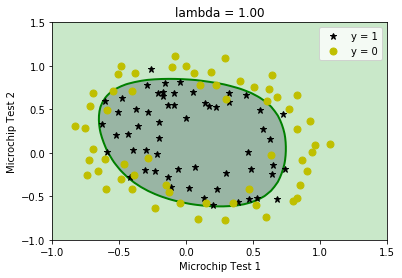

In [16]:

plotDecisionBoundary(plotData, theta, X, y)
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend(['y = 1', 'y = 0'])
plt.grid(False)
plt.title('lambda = %0.2f' % lambda_)

# Print results
print('Cost at theta found by optimize.minimize: {:.3f}'.format(cost))
# Compute accuracy on our training set
y_hat = myML.predict_LogisticR(theta, X)
print('Train Accuracy: %.1f %%' % (np.mean(y_hat == y) * 100))
print('Expected accuracy (with lambda = 1): 83.1 % (approx)\n')


### 2.5 Optional (ungraded) exercises

In this part of the exercise, you will get to try out different regularization parameters for the dataset to understand how regularization prevents overfitting.

Notice the changes in the decision boundary as you vary $\lambda$. See the following figures for the decision boundaries you should get for different values of $\lambda$. 
<table>
    <tr>
        <td style="text-align:center">
            No regularization (overfitting)<img src="Figures/ex2_decision_boundary3.png">
        </td>        
        <td style="text-align:center">
            Decision boundary with regularization
            <img src="Figures/ex2_decision_boundary2.png">
        </td>
        <td style="text-align:center">
            Decision boundary with too much regularization
            <img src="Figures/ex2_decision_boundary4.png">
        </td>        
    <tr>
</table>
With a small $\lambda$, you should find that the classifier gets almost every training example correct, but draws a very complicated boundary, thus overfitting the data. This is not a good decision boundary: for example, it predicts that a point at $x = (−0.25, 1.5)$ is accepted $(y = 1)$, which seems to be an incorrect decision given the training set.  

With a larger $\lambda$, you should see a plot that shows an simpler decision boundary which still separates the positives and negatives fairly well.  

However, if $\lambda$ is set to too high a value, you will not get a good fit and the decision boundary will not follow the data so well, thus underfitting the data.

Cost at theta found by optimize.minimize: 0.278
Train Accuracy: 87.3 %


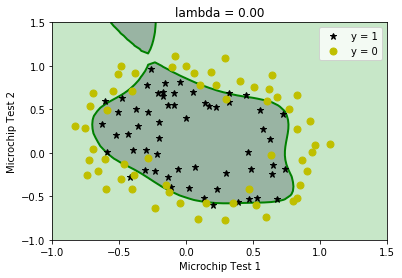

In [17]:
# Initialize fitting parameters
initial_theta = np.zeros(X.shape[1])

# Set regularization parameter lambda to 1 (you should vary this)
lambda_ = 0

# set options for optimize.minimize
options= {'maxiter': 100}

res = optimize.minimize(costFunctionReg,
                        initial_theta,
                        (X, y, lambda_),
                        jac=True,
                        method='TNC',
                        options=options)

# the fun property of OptimizeResult object returns
# the value of costFunction at optimized theta
cost = res.fun

# the optimized theta is in the x property of the result
theta = res.x

#plot
plotDecisionBoundary(plotData, theta, X, y)
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend(['y = 1', 'y = 0'])
plt.grid(False)
plt.title('lambda = %0.2f' % lambda_)

# Print results
print('Cost at theta found by optimize.minimize: {:.3f}'.format(cost))
# Compute accuracy on our training set
y_hat = myML.predict_LogisticR(theta, X)
print('Train Accuracy: %.1f %%' % (np.mean(y_hat == y) * 100))


Cost at theta found by optimize.minimize: 0.686
Train Accuracy: 61.0 %


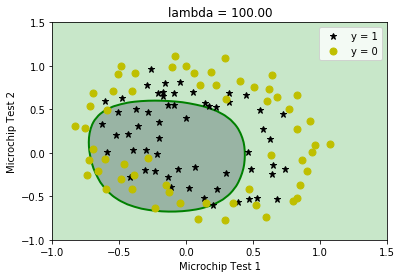

In [18]:
# Initialize fitting parameters
initial_theta = np.zeros(X.shape[1])

# Set regularization parameter lambda to 1 (you should vary this)
lambda_ = 100

# set options for optimize.minimize
options= {'maxiter': 100}

res = optimize.minimize(costFunctionReg,
                        initial_theta,
                        (X, y, lambda_),
                        jac=True,
                        method='TNC',
                        options=options)

# the fun property of OptimizeResult object returns
# the value of costFunction at optimized theta
cost = res.fun

# the optimized theta is in the x property of the result
theta = res.x

#plot
plotDecisionBoundary(plotData, theta, X, y)
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend(['y = 1', 'y = 0'])
plt.grid(False)
plt.title('lambda = %0.2f' % lambda_)

# Print results
print('Cost at theta found by optimize.minimize: {:.3f}'.format(cost))
# Compute accuracy on our training set
y_hat = myML.predict_LogisticR(theta, X)
print('Train Accuracy: %.1f %%' % (np.mean(y_hat == y) * 100))


### my 2.6 Optional - Compare with non-regularized Logistic Regression
reuse previously defined Cost function

Cost at theta found by optimize.minimize: 0.250
Train Accuracy: 88.1 %


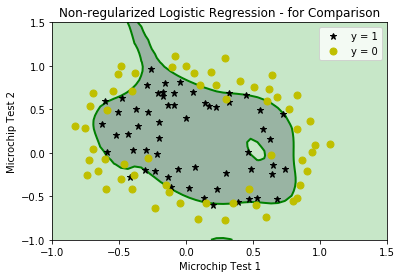

In [19]:
# set options for optimize.minimize
options= {'maxiter': 400}

# see documention for scipy's optimize.minimize  for description about
# the different parameters
# The function returns an object `OptimizeResult`
# We use truncated Newton algorithm for optimization which is 
# equivalent to MATLAB's fminunc
# See https://stackoverflow.com/questions/18801002/fminunc-alternate-in-numpy
res = optimize.minimize(myML.costFunction_LogisticR,
                        initial_theta,
                        (X, y),
                        jac=True,
                        method='TNC',
                        options=options)

# the fun property of `OptimizeResult` object returns
# the value of costFunction at optimized theta
cost = res.fun

# the optimized theta is in the x property
theta = res.x

#plot
plotDecisionBoundary(plotData, theta, X, y)
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend(['y = 1', 'y = 0'])
plt.grid(False)
plt.title("Non-regularized Logistic Regression - for Comparison")

# Print results
print('Cost at theta found by optimize.minimize: {:.3f}'.format(cost))
# Compute accuracy on our training set
y_hat = myML.predict_LogisticR(theta, X)
print('Train Accuracy: %.1f %%' % (np.mean(y_hat == y) * 100))

Non-regularized results look pretty good with training dataset, but the weird boundary indicates an overfitted model, which may not peform as well with new unseen examples.  


## Xtra
todo: Communicate results - the Model

### X0. Communicate Results - the Model
Hypothesis $h_\theta(x)$ is given by the logistic model  
Form: y_hat = theta0 + theta1 * x1 + theta2 * x2 + ... + theta_n * x_n

How to interpret the model
#### Probability of microchip passing the test =  theta0 + theta1 * x1 + theta2 * x2 + ... + theta_n * x_n

### X1. Evaluating logistic regression

After learning the parameters, you can use the model to predict whether a particular student will be admitted. For a student with an Exam 1 score of 45 and an Exam 2 score of 85, you should expect to see an admission
probability of 0.776. 

In [20]:
#Predict a single example
microchip_tests = X[0] #already feature mapped from 2 tests to 6 degree polynomials
print(microchip_tests[1:3])
y_hat=myML.sigmoid(np.dot(microchip_tests, theta))
print("Probability of microchip acceptance: ", y_hat)
print("Prediction:", y_hat >= 0.5)

[0.051267 0.69956 ]
Probability of microchip acceptance:  0.9452280126335111
Prediction: True


In [21]:
stop

NameError: name 'stop' is not defined

## 0. Appendix

Review of previously defined functions also useful here.

### 0.1 Logistic regression hypothesis and Sigmoid function


The logistic regression hypothesis is defined as:

$$ h_\theta(x) = g(\theta^T x)$$

where function $g$ is the sigmoid function. The sigmoid function is defined as: 

$$g(z) = \frac{1}{1+e^{-z}}$$.

In [22]:
#$mathcode:  
# math.e**(x) equals to np.exp(x)
#np.exp(1) returns e which is 2.718281828459045

Test sigmoid function: 
 - for large positive values, the sigmoid should be close to 1   
 - for large negative values, the sigmoid should be close to 0   
 - evaluating `sigmoid(0)` should give you exactly 0.5

In [23]:
#verify sigmoid works with scalar, vector and matrix
#z = 1
z = np.array([1000,0,-1000])
#z = np.array([[1000,0,-1000],[10,0,-10]])

myML.sigmoid(z)

array([1. , 0.5, 0. ])

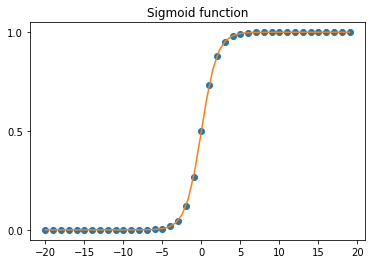

In [25]:
from scipy.interpolate import make_interp_spline, BSpline #to smooth the line between points

#visualize sigmoid function
z = np.arange(-20, 20, 1)
y = myML.sigmoid(z)

#plot smooth sigmoid 
z_smooth = np.linspace(np.array(z).min(), np.array(z).max(), 50)
spl = make_interp_spline(np.array(z), np.array(y), k=3)  # type: BSpline
y_smooth = spl(z_smooth)

#plot
plt.title("Sigmoid function")
plt.plot(z, y, 'o')
plt.plot(z_smooth, y_smooth, '-')
plt.yticks([0,0.5,1])
plt.show()